In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
import math

def crop_image(input, x, y, width, height):

    # 裁剪图像 x,y center
    ymin = max(y- int(height/2),0)
    xmin = max(x- int(width/2),0)
    ymax = min(y + int(height/2),1922)
    xmax = min(x + int(width/2),2560)
    output = input[ymin:ymax, xmin: xmax]
    return output


def detect(path):
    image = cv2.imread(path)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # 定义金黄色的 HSV 颜色范围
    lower_golden = np.array([25, 200, 50])
    upper_golden = np.array([34, 255, 255])
    
    # 创建金黄色的掩膜
    mask = cv2.inRange(hsv_image, lower_golden, upper_golden)
    
    # 将掩膜应用于原始图像
    result = cv2.bitwise_and(image, image, mask=mask)
    #plt.imshow(result)
    #plt.show()
    #text = pytesseract.image_to_string(result)
    #print(text)
    
    gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
    k= 5
    blur = cv2.GaussianBlur(gray, (k, k), 0)
    thresh = cv2.threshold(blur, 200, 255, cv2.THRESH_BINARY_INV)[1]
    edges = cv2.Canny(thresh, 50, 150)
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    alignment_marks = []
    count = 0
    centers = [] 
    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        M = cv2.moments(contour)
    
        #print(area,perimeter)
        #alignment_marks.append(contour)
        #50x if  9000 >area > 7000 and 460 > perimeter > 400:
           
        if 100 > perimeter > 70:
            count += 1
            if area > 20:
                pass
                #print(area,perimeter)
            if 350 >area > 200:
                alignment_marks.append(contour)
                #print(area,perimeter)
                cv2.drawContours(image, alignment_marks, -1, (255, 255, 255), 5)
             # 计算轮廓的中心坐标
                if M["m00"] > 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                    #cv2.circle(image, (cx, cy), 20, (0, 0, 0), -1)
                    # 在图像上绘制中心点
                    centers.append([cx,cy])
                    
    return result, centers


def text(image):
    data = pytesseract.image_to_data(image,lang='eng', config = "--psm 6 --oem 1",output_type=pytesseract.Output.DICT)
    return data['text']


def calculate_distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

def find_farthest_points(alignments):
    max_distance = 0
    farthest_points = None
    points= [point["xy"] for point in alignments]
    index1 = 0
    index2 = 0
    # 遍历所有点对
    for i in range(0,len(points)-1):
        for j in range(i+1, len(points)):
            distance = calculate_distance(points[i], points[j])
    
            # 更新最远距离和点对
            if distance > max_distance:
                max_distance = distance
                #farthest_points = (points[i], points[j])
                index1 = j
                index2 = i
    farthest_points = [alignments[index1],alignments[index2]]
    
    return farthest_points

      

def convert(alm):
    
    letters='ABCDEFGHIJKLMNO'
    m=letters.index(alm[1])
    n=letters.index(alm[0])

    x = -2800 + m * 200
    y = 2800 - n * 200
    return x,y 
    

In [31]:
convert('OO')

(0, 0)

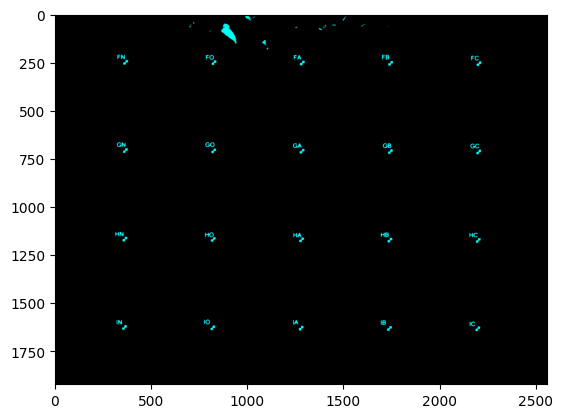

In [19]:
plt.imshow(result)
plt.show()

In [20]:
centers[20]

[999, 16]

In [8]:
path='C:\\Users\\wuyx0\\Desktop\\coda\\autoalign\\pics\\33.jpg'
#path= 'txt.png'
image = cv2.imread(path)

result, centers = detect(path)
alignments = []

for center in centers:
    x,y =tuple(center)
    crop=crop_image(result,x,y,100,100)
    
    #print(text(crop)[20])
    letters='ABCDEFGHIJKLMNO'
    
    for i in text(crop):
        #print(i)
        if len(i) == 2:
            if i[0] in  letters and i[1] in letters:
                alignments.append(dict(text=i,xy=(x,y)))
                break
    
    
    
print(alignments)

[{'text': 'IB', 'xy': (1736, 1632)}, {'text': 'IN', 'xy': (360, 1627)}, {'text': 'HC', 'xy': (2197, 1175)}, {'text': 'HA', 'xy': (1279, 1172)}, {'text': 'HO', 'xy': (821, 1170)}, {'text': 'HN', 'xy': (362, 1168)}, {'text': 'GC', 'xy': (2199, 715)}, {'text': 'GB', 'xy': (1741, 714)}, {'text': 'GA', 'xy': (1282, 712)}, {'text': 'GO', 'xy': (823, 710)}, {'text': 'GN', 'xy': (365, 708)}, {'text': 'FC', 'xy': (2201, 257)}, {'text': 'FB', 'xy': (1742, 255)}, {'text': 'FA', 'xy': (1283, 254)}, {'text': 'FO', 'xy': (825, 252)}, {'text': 'FN', 'xy': (365, 250)}]


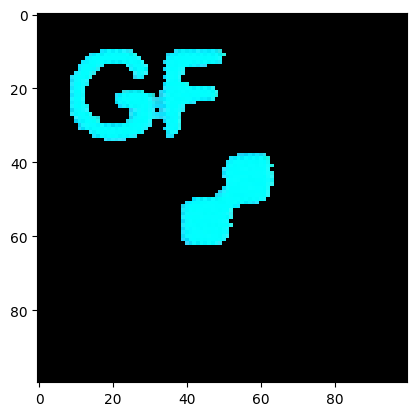

['', '', '', '', 'GF', '', '&']


In [32]:
[x,y]=centers[0]
crop1=crop_image(result,x,y,100,100)
plt.imshow(crop1)
plt.show()
print(text(crop1))

In [51]:
find_farthest_points(alignments)

[{'text': 'DA', 'xy': (161, 247)}, {'text': 'GF', 'xy': (2449, 1632)}]

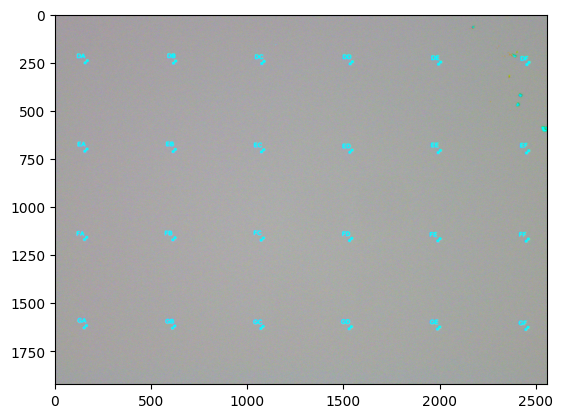

In [56]:
path='C:\\Users\\wuyx0\\Desktop\\coda\\autoalign\\pics\\33.jpg'
#path= 'txt.png'
image = cv2.imread(path)
plt.imshow(image)
plt.show()

In [35]:
align=[]
for n in range(1,71):
    path =  'C:\\Users\\wuyx0\\Desktop\\coda\\autoalign\\pics\\'+ str(n) +'.jpg'
    result, centers = detect(path)
    alignments = []
    for center in centers:
        x,y =tuple(center)
        crop=crop_image(result,x,y,100,100)
        #plt.imshow(crop)
        #plt.show()
        for i in text(crop):
            if len(i) == 2:
                letters='ABCDEFGHIJKLMNO'
                if i[0] in letters and i[1] in letters:
                    alignments.append(dict(text=i,xy=(x,y)))
                    break
    #print(find_farthest_points(alignments))
    align.append(find_farthest_points(alignments))

In [36]:
align

[[{'text': 'AF', 'xy': (2449, 304)}, {'text': 'DA', 'xy': (151, 1671)}],
 [{'text': 'DA', 'xy': (161, 247)}, {'text': 'GF', 'xy': (2449, 1632)}],
 [{'text': 'GF', 'xy': (2461, 223)}, {'text': 'JA', 'xy': (163, 1590)}],
 [{'text': 'JF', 'xy': (2465, 258)}, {'text': 'MA', 'xy': (167, 1626)}],
 [{'text': 'MF', 'xy': (2471, 279)}, {'text': 'AA', 'xy': (173, 1646)}],
 [{'text': 'AA', 'xy': (167, 283)}, {'text': 'OF', 'xy': (2455, 1667)}],
 [{'text': 'DA', 'xy': (173, 238)}, {'text': 'GF', 'xy': (2461, 1623)}],
 [{'text': 'GA', 'xy': (178, 236)}, {'text': 'JF', 'xy': (2466, 1621)}],
 [{'text': 'JF', 'xy': (2478, 233)}, {'text': 'MA', 'xy': (179, 1601)}],
 [{'text': 'LA', 'xy': (188, 179)}, {'text': 'NF', 'xy': (2477, 1106)}],
 [{'text': 'LJ', 'xy': (2179, 177)}, {'text': 'NF', 'xy': (340, 1089)}],
 [{'text': 'IF', 'xy': (338, 228)}, {'text': 'LJ', 'xy': (2167, 1611)}],
 [{'text': 'FF', 'xy': (333, 239)}, {'text': 'HJ', 'xy': (2164, 1164)}],
 [{'text': 'CJ', 'xy': (2161, 344)}, {'text': 'FF',

In [1]:
coor = [[{'text': 'AF', 'xy': (2449, 304)}, {'text': 'DA', 'xy': (151, 1671)}],
 [{'text': 'DA', 'xy': (161, 247)}, {'text': 'GF', 'xy': (2449, 1632)}],
 [{'text': 'GF', 'xy': (2461, 223)}, {'text': 'JA', 'xy': (163, 1590)}],
 [{'text': 'JF', 'xy': (2465, 258)}, {'text': 'MA', 'xy': (167, 1626)}],
 [{'text': 'MF', 'xy': (2471, 279)}, {'text': 'AA', 'xy': (173, 1646)}],
 [{'text': 'AA', 'xy': (167, 283)}, {'text': 'OF', 'xy': (2455, 1667)}],
 [{'text': 'DA', 'xy': (173, 238)}, {'text': 'GF', 'xy': (2461, 1623)}],
 [{'text': 'GA', 'xy': (178, 236)}, {'text': 'JF', 'xy': (2466, 1621)}],
 [{'text': 'JF', 'xy': (2478, 233)}, {'text': 'MA', 'xy': (179, 1601)}],
 [{'text': 'LA', 'xy': (188, 179)}, {'text': 'NF', 'xy': (2477, 1106)}],
 [{'text': 'LJ', 'xy': (2179, 177)}, {'text': 'NF', 'xy': (340, 1089)}],
 [{'text': 'IF', 'xy': (338, 228)}, {'text': 'LJ', 'xy': (2167, 1611)}],
 [{'text': 'FF', 'xy': (333, 239)}, {'text': 'HJ', 'xy': (2164, 1164)}],
 [{'text': 'CJ', 'xy': (2161, 344)}, {'text': 'FF', 'xy': (321, 1713)}],
 [{'text': 'OJ', 'xy': (2157, 306)}, {'text': 'CF', 'xy': (317, 1675)}],
 [{'text': 'LF', 'xy': (316, 280)}, {'text': 'OJ', 'xy': (2146, 1663)}],
 [{'text': 'IF', 'xy': (311, 289)}, {'text': 'KJ', 'xy': (2142, 1214)}],
 [{'text': 'FJ', 'xy': (2141, 285)}, {'text': 'IF', 'xy': (301, 1655)}],
 [{'text': 'CF', 'xy': (300, 289)}, {'text': 'FJ', 'xy': (2129, 1673)}],
 [{'text': 'AF', 'xy': (294, 617)}, {'text': 'CJ', 'xy': (2125, 1542)}],
 [{'text': 'AJ', 'xy': (327, 611)}, {'text': 'CN', 'xy': (2159, 1535)}],
 [{'text': 'CJ', 'xy': (332, 292)}, {'text': 'FN', 'xy': (2161, 1676)}],
 [{'text': 'FJ', 'xy': (338, 276)}, {'text': 'IN', 'xy': (2167, 1658)}],
 [{'text': 'JJ', 'xy': (342, 675)}, {'text': 'LN', 'xy': (2173, 1600)}],
 [{'text': 'LN', 'xy': (2185, 251)}, {'text': 'OJ', 'xy': (346, 1619)}],
 [{'text': 'ON', 'xy': (2191, 203)}, {'text': 'CJ', 'xy': (351, 1573)}],
 [{'text': 'CJ', 'xy': (361, 320)}, {'text': 'FN', 'xy': (2190, 1703)}],
 [{'text': 'FN', 'xy': (2201, 300)}, {'text': 'HJ', 'xy': (363, 1211)}],
 [{'text': 'IJ', 'xy': (372, 194)}, {'text': 'LN', 'xy': (2202, 1577)}],
 [{'text': 'LN', 'xy': (2213, 187)}, {'text': 'NJ', 'xy': (374, 1098)}],
 [{'text': 'LN', 'xy': (377, 173)}, {'text': 'NC', 'xy': (2209, 1098)}],
 [{'text': 'JC', 'xy': (2203, 756)}, {'text': 'LN', 'xy': (365, 1666)}],
 [{'text': 'FC', 'xy': (2201, 257)}, {'text': 'IN', 'xy': (360, 1627)}],
 [{'text': 'CN', 'xy': (360, 218)}, {'text': 'FC', 'xy': (2190, 1601)}],
 [{'text': 'ON', 'xy': (354, 291)}, {'text': 'BC', 'xy': (2186, 1214)}],
 [{'text': 'MC', 'xy': (2181, 755)}, {'text': 'ON', 'xy': (343, 1665)}],
 [{'text': 'JC', 'xy': (2175, 755)}, {'text': 'LN', 'xy': (337, 1665)}],
 [{'text': 'FC', 'xy': (2172, 262)}, {'text': 'IN', 'xy': (332, 1630)}],
 [{'text': 'CN', 'xy': (313, 279)}, {'text': 'FC', 'xy': (2143, 1662)}],
 [{'text': 'AC', 'xy': (2141, 721)}, {'text': 'CN', 'xy': (303, 1631)}],
 [{'text': 'AC', 'xy': (391, 709)}, {'text': 'BG', 'xy': (2225, 1174)}],
 [{'text': 'OG', 'xy': (2231, 748)}, {'text': 'FC', 'xy': (393, 1658)}],
 [{'text': 'FC', 'xy': (403, 312)}, {'text': 'IG', 'xy': (2232, 1694)}],
 [{'text': 'IG', 'xy': (2244, 261)}, {'text': 'KC', 'xy': (405, 1173)}],
 [{'text': 'LG', 'xy': (2249, 273)}, {'text': 'NC', 'xy': (411, 1183)}],
 [{'text': 'AC', 'xy': (417, 768)}, {'text': 'CG', 'xy': (2249, 1692)}],
 [{'text': 'CG', 'xy': (2261, 318)}, {'text': 'FC', 'xy': (419, 1689)}],
 [{'text': 'FC', 'xy': (430, 277)}, {'text': 'IG', 'xy': (2259, 1660)}],
 [{'text': 'ID', 'xy': (894, 255)}, {'text': 'LG', 'xy': (2265, 1635)}],
 [{'text': 'LG', 'xy': (2276, 238)}, {'text': 'NC', 'xy': (437, 1149)}],
 [{'text': 'LK', 'xy': (2191, 232)}, {'text': 'NF', 'xy': (353, 1142)}],
 [{'text': 'JK', 'xy': (2183, 725)}, {'text': 'LG', 'xy': (345, 1636)}],
 [{'text': 'FG', 'xy': (345, 207)}, {'text': 'HK', 'xy': (2177, 1131)}],
 [{'text': 'CG', 'xy': (339, 302)}, {'text': 'FK', 'xy': (2169, 1683)}],
 [{'text': 'OK', 'xy': (2169, 302)}, {'text': 'CG', 'xy': (329, 1672)}],
 [{'text': 'LK', 'xy': (2163, 271)}, {'text': 'OG', 'xy': (324, 1639)}],
 [{'text': 'IG', 'xy': (322, 299)}, {'text': 'LK', 'xy': (2153, 1681)}],
 [{'text': 'FK', 'xy': (2152, 257)}, {'text': 'IG', 'xy': (312, 1627)}],
 [{'text': 'CG', 'xy': (312, 267)}, {'text': 'FK', 'xy': (2141, 1651)}],
 [{'text': 'AG', 'xy': (304, 679)}, {'text': 'CK', 'xy': (2136, 1603)}],
 [{'text': 'AK', 'xy': (347, 671)}, {'text': 'CN', 'xy': (1719, 1594)}],
 [{'text': 'CN', 'xy': (1716, 226)}, {'text': 'FK', 'xy': (347, 1626)}],
 [{'text': 'FK', 'xy': (357, 260)}, {'text': 'IN', 'xy': (1729, 1640)}],
 [{'text': 'IK', 'xy': (363, 267)}, {'text': 'LN', 'xy': (1734, 1648)}],
 [{'text': 'LK', 'xy': (369, 237)}, {'text': 'ON', 'xy': (1740, 1619)}],
 [{'text': 'OK', 'xy': (375, 287)}, {'text': 'CN', 'xy': (1745, 1670)}],
 [{'text': 'CN', 'xy': (1756, 293)}, {'text': 'FK', 'xy': (374, 1666)}],
 [{'text': 'FK', 'xy': (385, 302)}, {'text': 'IN', 'xy': (1755, 1684)}],
 [{'text': 'HN', 'xy': (1765, 298)}, {'text': 'KK', 'xy': (383, 1669)}],
 [{'text': 'KN', 'xy': (1771, 196)}, {'text': 'NK', 'xy': (389, 1567)}]]


In [2]:
print(coor)

[[{'text': 'AF', 'xy': (2449, 304)}, {'text': 'DA', 'xy': (151, 1671)}], [{'text': 'DA', 'xy': (161, 247)}, {'text': 'GF', 'xy': (2449, 1632)}], [{'text': 'GF', 'xy': (2461, 223)}, {'text': 'JA', 'xy': (163, 1590)}], [{'text': 'JF', 'xy': (2465, 258)}, {'text': 'MA', 'xy': (167, 1626)}], [{'text': 'MF', 'xy': (2471, 279)}, {'text': 'AA', 'xy': (173, 1646)}], [{'text': 'AA', 'xy': (167, 283)}, {'text': 'OF', 'xy': (2455, 1667)}], [{'text': 'DA', 'xy': (173, 238)}, {'text': 'GF', 'xy': (2461, 1623)}], [{'text': 'GA', 'xy': (178, 236)}, {'text': 'JF', 'xy': (2466, 1621)}], [{'text': 'JF', 'xy': (2478, 233)}, {'text': 'MA', 'xy': (179, 1601)}], [{'text': 'LA', 'xy': (188, 179)}, {'text': 'NF', 'xy': (2477, 1106)}], [{'text': 'LJ', 'xy': (2179, 177)}, {'text': 'NF', 'xy': (340, 1089)}], [{'text': 'IF', 'xy': (338, 228)}, {'text': 'LJ', 'xy': (2167, 1611)}], [{'text': 'FF', 'xy': (333, 239)}, {'text': 'HJ', 'xy': (2164, 1164)}], [{'text': 'CJ', 'xy': (2161, 344)}, {'text': 'FF', 'xy': (321, 

In [3]:
path='C:\\Users\\wuyx0\\Desktop\\coda\\autoalign\\pics\\'+str(33)+'.jpg'



ValueError: invalid literal for int() with base 10: 'C:\\Users\\wuyx0\\Desktop\\coda\\autoalign\\pics\\33.jpg'

In [18]:
math.atan(-3104/4249)*180/math.pi+180

143.85094401450718

In [16]:
calculate_distance((151,-1671),(-2800,2200))

4867.549897022115

In [19]:
180+math.atan(3871/-2951)*180/math.pi

127.3195532818616

In [13]:
calculate_distance((2449,-304),(-1800,2800))

5262.016438590818

In [ ]:


print("'''
_-IMAGE
_ATTACH
"C:/Users/wuyx0/Desktop/coda/autoalign/pics2/1.jpg"
0.0,-1922.0,0.0
2560
0.0
ALIGN
1

2449,-304
5262.016438590818,143.85094401450718
151,-1671
4867.549897022115,127.3195532818616

y

      
      '''")

In [ ]:
def generate_scr_file(file_path, commands):
    with open(file_path, 'w') as f:
        for command in commands:
            f.write(command + '\n')

# 示例用法
commands = [
    '_-IMAGE',
    '0,0,0',
    '10,10,0',
    'CIRCLE',
    '5,5,0',
    '3',
    'SAVE'
]

file_path = ''
generate_scr_file(file_path, commands)

In [92]:
file_path = 'C:\\Users\\wuyx0\\Desktop\\coda\\autoalign\\align_images.scr'
for i in range(16,26):
    xs1,ys1 = coor[i-1][0]['xy']
    xs2,ys2 = coor[i-1][1]['xy']

    xd1,yd1 = convert(coor[i-1][0]['text'])
    xd2,yd2 = convert(coor[i-1][1]['text'])

    yd1 = yd1 #-3000
    yd2 = yd2 #-3000
    
    commands = [
    '_-IMAGE',
    '_ATTACH',
    '"'+'C:/Users/wuyx0/Desktop/coda/autoalign/pics/' + str(i)+'.jpg'+'"',
    '0.0,-1922.0,0.0',
    '2560',
    '0.0',
    'ALIGN',
    str(i),
    '',
    str(xs1)+','+str(-ys1)+',0.0',
    #'@'+str(xd1-xs1)+','+str(yd1-ys1)+',0.0',
    str(xd1)+','+str(yd1)+',0.0',
    str(xs2)+','+str(-ys2)+',0.0',
    #'@'+str(xd2-xs2)+','+str(yd2-ys2)+',0.0',
    str(xd2)+','+str(yd2)+',0.0',
    '',
    'y',      
]
    file_path = 'C:\\Users\\wuyx0\\Desktop\\coda\\autoalign\\scr\\align_images'+str(i)+'.scr'
    with open(file_path, 'w') as f:
        for command in commands:
            f.write(command + '\n')
    f.close()            
      

In [64]:
converted1= []
converted2= []
for co in coor:
    converted1.append(convert(co[0]['text']))
    converted2.append(convert(co[1]['text']))
print(converted1)

[(-1800, 2800), (-2800, 2200), (-1800, 1600), (-1800, 1000), (-1800, 400), (-2800, 2800), (-2800, 2200), (-2800, 1600), (-1800, 1000), (-2800, 600), (-1000, 600), (-1800, 1200), (-1800, 1800), (-1000, 2400), (-1000, 0), (-1800, 600), (-1800, 1200), (-1000, 1800), (-1800, 2400), (-1800, 2800), (-1000, 2800), (-1000, 2400), (-1000, 1800), (-1000, 1000), (-200, 600), (-200, 0), (-1000, 2400), (-200, 1800), (-1000, 1200), (-200, 600), (-200, 600), (-2400, 1000), (-2400, 1800), (-200, 2400), (-200, 0), (-2400, 400), (-2400, 1000), (-2400, 1800), (-200, 2400), (-2400, 2800), (-2400, 2800), (-1600, 0), (-2400, 1800), (-1600, 1200), (-1600, 600), (-2400, 2800), (-1600, 2400), (-2400, 1800), (-2200, 1200), (-1600, 600), (-800, 600), (-800, 1000), (-1600, 1800), (-1600, 2400), (-800, 0), (-800, 600), (-1600, 1200), (-800, 1800), (-1600, 2400), (-1600, 2800), (-800, 2800), (-200, 2400), (-800, 1800), (-800, 1200), (-800, 600), (-800, 0), (-200, 2400), (-800, 1800), (-200, 1400), (-200, 800)]


In [38]:
x1,y1 = coor[0][0]['xy']

In [39]:
x1

2449

In [65]:
converted1[3]

(-1800, 1000)

In [66]:
converted2[3]

(-2800, 400)

FF HJ


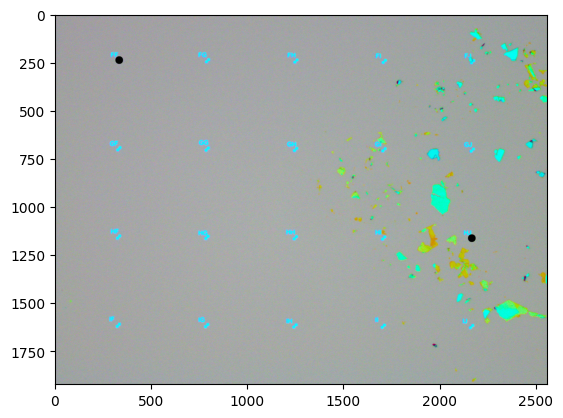

In [88]:
number = 13
path='C:\\Users\\wuyx0\\Desktop\\coda\\autoalign\\pics\\'+str(number)+'.jpg'
image = cv2.imread(path)

cv2.circle(image, coor[number-1][0]['xy'], 20, (0, 0, 0), -1)
cv2.circle(image, coor[number-1][1]['xy'], 20, (0, 0, 0), -1)
print(coor[number-1][0]['text'],coor[number-1][1]['text'])
plt.imshow(image)
plt.show()

In [91]:
coor[12][0]['xy']

(333, 239)

In [75]:
convert("MA")

(-2800, 400)